In [158]:
import tensorflow as tf
# from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import backend as K
import pickle 
import random

from src import data
from src import error_function

jobs = 6 # number of cores
config = tf.ConfigProto(intra_op_parallelism_threads=jobs,
                     inter_op_parallelism_threads=jobs,
                     allow_soft_placement=True,
                     device_count={'CPU': jobs})
session = tf.Session(config=config)
K.set_session(session)

In [159]:
## loading the model
model = keras.models.load_model('data/models/CRNN.h5',         
        custom_objects={ 
            'class_mae': error_function.class_mae,
            'exp': keras.backend.exp
        })

/Users/jordynaus/Documents/Artificial Intelligence/Master/2021 Sem. 2/Automatic Speech Recognition/asr/lib/python3.7/site-packages/keras/engine/base_layer.py:1179: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="conv1", activity_regularizer=None, trainable=True, activation="relu", kernel_size=(3, 3), filters=64, strides=[1, 1], padding="valid", data_format="channels_first", kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None, use_bias=True)`
  return cls(**config)
/Users/jordynaus/Documents/Artificial Intelligence/Master/2021 Sem. 2/Automatic Speech Recognition/asr/lib/python3.7/site-packages/keras/engine/base_layer.py:1179: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(name="conv2", activity_regularizer=None, trainable=True, activation="relu", kernel_size=(3, 3), filters=32, strides=[1, 1], padding="valid", data_format="channels_first", kernel_initializer="glorot

In [3]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero1 (ZeroPadding2D)        (None, 1, 500, 201)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 498, 199)      640       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 496, 197)      18464     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 165, 65)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 128, 163, 63)      36992     
_________________________________________________________________
conv4 (Conv2D)               (None, 64, 161, 61)       73792     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 64, 53, 20)       

In [123]:
## load dataset
train_dataset, val_dataset = data.create_tensorflow_dataset('./data/trainset100/stft/', batch_size=32, val_split = 0.3)

Found 7860 images belonging to 11 classes.
Found 3363 images belonging to 11 classes.


In [5]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs = 25)

Epoch 1/25
246/246 [==============================] - 1913s 8s/step - loss: 2.0451 - accuracy: 0.3037 - class_mae: 1.8333 - val_loss: 0.8384 - val_accuracy: 0.4374 - val_class_mae: 0.7736
Epoch 2/25
246/246 [==============================] - 1896s 8s/step - loss: 1.1695 - accuracy: 0.4925 - class_mae: 0.8780 - val_loss: 0.9076 - val_accuracy: 0.5254 - val_class_mae: 0.6698
Epoch 3/25
246/246 [==============================] - 1897s 8s/step - loss: 1.0915 - accuracy: 0.5160 - class_mae: 0.7439 - val_loss: 0.4189 - val_accuracy: 0.5010 - val_class_mae: 0.6792
Epoch 4/25
246/246 [==============================] - 1892s 8s/step - loss: 1.0424 - accuracy: 0.5425 - class_mae: 0.6382 - val_loss: 2.7634 - val_accuracy: 0.4796 - val_class_mae: 0.6509
Epoch 5/25
246/246 [==============================] - 1890s 8s/step - loss: 1.0138 - accuracy: 0.5570 - class_mae: 0.5366 - val_loss: 1.2345 - val_accuracy: 0.5260 - val_class_mae: 0.7264
Epoch 6/25
246/246 [==============================] - 1894s 

In [6]:
model.save('data/models/CRNN_100.h5', overwrite=True, include_optimizer=True)

In [7]:
with open('data/history100', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [9]:
infile = open('data/history100','rb')
new_dict = pickle.load(infile)
infile.close()

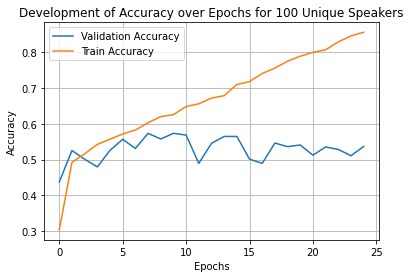

In [37]:
plt.figure(facecolor='white')
plt.plot(new_dict.get('val_accuracy'), label = 'Validation Accuracy')
plt.plot(new_dict.get('accuracy'), label = 'Train Accuracy')
plt.title('Development of Accuracy over Epochs for 100 Unique Speakers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig('data/100_acc.png', dpi=300, bbox_inches='tight')
plt.show()


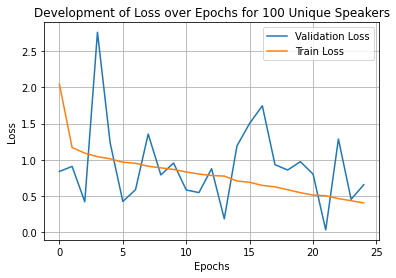

In [38]:
plt.figure(facecolor='white')
plt.plot(new_dict.get('val_loss'), label = 'Validation Loss')
plt.plot(new_dict.get('loss'), label = 'Train Loss')
plt.title('Development of Loss over Epochs for 100 Unique Speakers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig('data/100_loss.png',dpi=300, bbox_inches='tight')
plt.show()


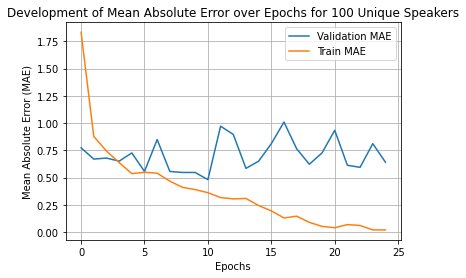

In [39]:
plt.figure(facecolor='white')
plt.plot(new_dict.get('val_class_mae'), label = 'Validation MAE')
plt.plot(new_dict.get('class_mae'), label = 'Train MAE')
plt.title('Development of Mean Absolute Error over Epochs for 100 Unique Speakers')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.grid()
plt.savefig('data/100_mae.png', dpi=300, bbox_inches='tight')
plt.show()


In [349]:
def freq_mask(input, param, name=None):
    """
    Apply masking to a spectrogram in the freq domain.
    Args:
      input: An audio spectogram.
      param: Parameter of freq masking.
      name: A name for the operation (optional).
    Returns:
      A tensor of spectrogram.
    """
    input = tf.convert_to_tensor(input)
    
    freq_max = tf.shape(input)[0]
    f = tf.random.uniform(shape=(), minval=0, maxval=param, dtype=tf.dtypes.int32)
    f0 = tf.random.uniform(
        shape=(), minval=0, maxval=freq_max - f, dtype=tf.dtypes.int32
    )
    
    indices = tf.squeeze(tf.reshape(tf.range(freq_max), (1, -1)))
    
    condition = tf.math.logical_and(
        tf.math.greater_equal(indices, f0), tf.math.less(indices, f0 + f)
    )
    #with tf.Session() as sess: print(condition.eval(session=sess))
    return tf.where(condition, tf.zeros([input.shape[0], input.shape[1]], input.dtype), input)

(1, 500, 201)
(201, 500)


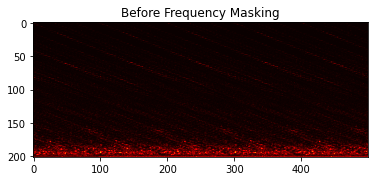

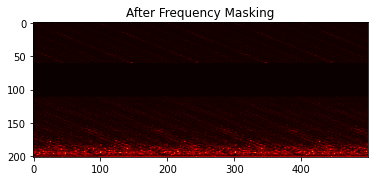

(1, 500, 201)
(201, 500)


KeyboardInterrupt: 

In [360]:
for img in train_dataset[0][0]:
    print(img.shape)
#     plt.plot(np.squeeze(img))
#     plt.show()
    img = tf.reshape(img[0], [img[0].shape[1], img[0].shape[0]])
    print(img.shape)
    with tf.Session() as sess:
        plt.imshow(img.eval(session = sess), cmap = 'hot')
        plt.title('Before Frequency Masking')
        plt.show()
    
        #print(img.shape)
        plt.imshow(freq_mask(img, param = 100).eval(session = sess), cmap = 'hot')
        plt.title('After Frequency Masking')
        plt.show()

In [346]:
test = tf.constant([[1,2,3,4]])

In [324]:
with tf.Session() as sess: print(test.eval(session = sess))

[[1 2 3 4]]


In [326]:
test_reshape = tf.reshape([test], shape = [1, test.shape[0]])

ValueError: Cannot reshape a tensor with 4 elements to shape [1,1] (1 elements) for 'Reshape_125' (op: 'Reshape') with input shapes: [1,1,4], [2] and with input tensors computed as partial shapes: input[1] = [1,1].

In [309]:
with tf.Session() as sess: print(test_repeat.eval(session = sess))

[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 ...
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]


In [316]:
test_reshape = tf.reshape([test], shape = [test.shape[1], test.shape[0]])

IndexError: list index out of range

In [318]:
with tf.Session() as sess: print(test_reshape.eval(session = sess))

NameError: name 'test_reshape' is not defined